
# Notebook version of DP_GP_cluster.py
- Created on: 242802
- Last modified: 242902

In [154]:
import matplotlib.pyplot as plt

from DP_GP import plot as dp_plt
from DP_GP import utils
from DP_GP import core as core
from DP_GP import cluster_tools

import pandas as pd
import numpy as np
import numpy.linalg as nl
import scipy
import GPy
import polars as pl

# import standard library dependencies:
import collections
import time
import copy
import argparse
import os
import sys
import cProfile

In [82]:
%alias_magic t timeit

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [83]:
def squared_dist_two_matrices(S, S_new):   
    '''Compute the squared distance between two numpy arrays/matrices.'''
    diff = S - S_new
    sq_dist = np.sum(np.dot(diff, diff))
    return(sq_dist)

# pre-compute useful value
_LOG_2PI = np.log(2 * np.pi)

In [84]:
class dp_cluster():
    '''
    dp_cluster object is composed of 0 or more genes and is parameterized by a Gaussian process.
    
    :param members: 0 or more gene indices that belong to cluster
    :type members: list
    :param sigma_n: initial noise variance
    :type sigma_n: float
    :param X: vertically stacked array of time points
    :type X: numpy array of dimension 1 x P, where P = number of time points
    :param iter_num_at_birth: iteration when cluster created
    :type iter_num_at_birth: int
    
    :rtype: dp_cluster object
    
    '''
    def __init__(self, members, X, Y=None, sigma_n=0.2, iter_num_at_birth=0, fast=False):
        
        self.dob = iter_num_at_birth # dob = date of birth, i.e. GS iteration number of creation
        self.members = members # members is a list of gene indices that belong to this cluster.
        self.size = len(self.members) # how many members?
        self.model_optimized = False # a newly created cluster is not optimized
        self.fast = fast
        
        # it may be beneficial to keep track of neg. log likelihood and hyperparameters over iterations
        self.sigma_f_at_iters, self.sigma_n_at_iters, self.l_at_iters, self.NLL_at_iters, self.update_iters = [],[],[],[],[]
        
        self.t = X
        
        # noise variance is initially set to a constant (and possibly estimated) value
        self.sigma_n = sigma_n
        if Y is not None:
            if not self.fast:
                # remove missing data
                self.X = np.vstack([x for j in range(Y.shape[1]) for x in self.t[~np.isnan(Y[:,j])].flatten()])
            else:
                self.X = X
        else:
            self.X = self.t
        
        # Define a convariance kernel with a radial basis function and freely allow for a overall slope and bias
        self.kernel = GPy.kern.RBF(input_dim=1, variance = 1., lengthscale = 1.) + \
                      GPy.kern.Linear(input_dim=1, variances=0.001) + \
                      GPy.kern.Bias(input_dim=1, variance=0.001)
        self.K = self.kernel.K(self.X)
        if (self.size == 0):
            # for empty clusters, draw a mean vector from the GP prior
            self.Y = np.vstack(np.random.multivariate_normal(np.zeros(self.X.shape[0]), self.K, 1).flatten())
        else: 
            if not self.fast:
                # remove missing data
                self.Y = np.vstack([y for j in range(Y.shape[1]) for y in Y[:,j][~np.isnan(Y[:,j])].flatten()])
            else:
                self.Y = Y
        
        self.model = GPy.models.GPRegression(self.X, self.Y, self.kernel)
        self.model.Gaussian_noise = self.sigma_n**2
        self.mean, covK = self.model._raw_predict(self.t, full_cov=True)
        self.covK = self.kernel.K(self.t) + (self.sigma_n**2) * np.eye(self.t.shape[0])
        self.mean = self.mean.flatten()
        self.update_rank_U_and_log_pdet()
        
    def update_rank_U_and_log_pdet(self):
        ''' 
        Because covariance matrix is symmetric positive semi-definite,
        the eigendecomposition can be quickly computed and, from that,
        the pseudo-determinant. This will rapidly speed up multivariate
        normal likelihood calculations compared to e.g. scipy.stats.multivariate_normal.
        
        Code taken with little modification from:
        https://github.com/cs109/content/blob/master/labs/lab6/_multivariate.py
        '''
        s, u = scipy.linalg.eigh(self.covK, check_finite=False)
        eps = 1E6 * np.finfo('float64').eps * np.max(abs(s))
        d = s[s > eps]
        s_pinv  = np.array([0 if abs(l) <= eps else 1/l for l in s], dtype=float)
        self.rank = len(d)
        self.U = np.multiply(u, np.sqrt(s_pinv))
        self.log_pdet = np.sum(np.log(d))
        
    def add_member(self, new_member, iter_num):
        ''' 
        Add a member to this cluster and increment size.
        '''
        self.members += [new_member]
        self.size += 1
        self.model_optimized = False
        
    def remove_member(self, old_member, iter_num):
        '''
        Remove a member from this cluster and decrement size.
        '''
        self.members = [member for member in self.members if member !=  old_member ]
        self.size -= 1
        self.model_optimized = False
        
    def update_cluster_attributes(self, gene_expression_matrix, sigma_n2_shape=12, sigma_n2_rate=2, length_scale_mu=0., length_scale_sigma=1., sigma_f_mu=0., sigma_f_sigma=1., iter_num=0, max_iters=1000, optimizer='lbfgsb', sparse_regression=False, fast=False):
        '''
        For all the clusters greater than size 1, update their Gaussian process hyperparameters,
        then return clusters.
        
        :param iter_num: current Gibbs sampling iteration
        :type iter_num: int
        :param clusters: dictionary of dp_cluster objects
        :type clusters: dict
        
        :returns: clusters: dictionary of dp_cluster objects
        :rtype: dict
        
        '''
        
        if (self.size > 0):
            
            if not self.model_optimized:
                
                # update model and associated hyperparameters
                gene_expression_matrix = np.array(gene_expression_matrix)
                if not self.fast:
                    Y = np.array(np.mat(gene_expression_matrix[self.members,:])).T
                    self.X = np.vstack([x for j in range(Y.shape[1]) for x in self.t[~np.isnan(Y[:,j])].flatten()])
                    self.Y = np.vstack([y for j in range(Y.shape[1]) for y in Y[:,j][~np.isnan(Y[:,j])].flatten()])
                else:
                    self.Y = np.array(np.mat(gene_expression_matrix[self.members,:])).T
                
#                 print(self.X)
#                 print("shape(self.X)", self.X.shape)
#                 print(self.Y)
#                 print("shape(self.Y)", self.Y.shape)
                
#                 self.K = self.kernel.K(self.X)
                if not sparse_regression or self.size <= 20:
                    self.model = GPy.models.GPRegression(X=self.X, Y=self.Y, kernel=self.kernel)
                else:
                    self.model = GPy.models.SparseGPRegression(X=self.X, Y=self.Y, kernel=self.kernel, Z=np.vstack(self.t))
                
                # for some reason, must re-set prior on Gaussian noise at every update:
                self.model.Gaussian_noise.set_prior(GPy.priors.InverseGamma(sigma_n2_shape, sigma_n2_rate), warning=False)                
                self.model.sum.rbf.lengthscale.set_prior(GPy.priors.LogGaussian(length_scale_mu, length_scale_sigma), warning=False)
                self.model.sum.rbf.variance.set_prior(GPy.priors.LogGaussian(sigma_f_mu, sigma_f_sigma), warning=False)
                self.model_optimized = True
                self.model.optimize(optimizer, max_iters=max_iters)
                
                self.sigma_n = np.sqrt(self.model['Gaussian_noise'][0])
                if not self.fast:
                    mean, self.covK = self.model.predict(self.t, full_cov=True) #kern=self.model.kern)  
                    self.mean = mean.flatten()
                    self.K = self.kernel.K(self.t)
                else:
                    mean, self.covK = self.model.predict(self.X, full_cov=True, kern=self.model.kern)  
                    self.mean = np.hstack(mean.mean(axis=1))
                
                self.update_rank_U_and_log_pdet()
                
            # keep track of neg. log-likelihood and hyperparameters
            self.sigma_n_at_iters.append(self.sigma_n)
            self.sigma_f_at_iters.append(np.sqrt(self.model.sum.rbf.variance))
            self.l_at_iters.append(np.sqrt(self.model.sum.rbf.lengthscale))
            self.NLL_at_iters.append( - float(self.model.log_likelihood()) )
            self.update_iters.append(iter_num)
            
        else:
            # No need to do anything to empty clusters.
            # New mean trajectory will be drawn at every iteration according to the Gibb's sampling routine
            pass
            
        return self

In [88]:
class gibbs_sampler_gpu(object):
    
    def __init__(self,
                 gene_expression_matrix,
                 t,
                 max_num_iterations=1000, 
                 max_iters=1000, 
                 optimizer='lbfgsb', 
                 burnIn_phaseI=240, 
                 burnIn_phaseII=480, 
                 alpha=1., 
                 m=4, 
                 s=3, 
                 check_convergence=False, 
                 check_burnin_convergence=False, 
                 sparse_regression=False, 
                 fast=False, 
                 sigma_n_init=0.2, 
                 sigma_n2_shape=12., 
                 sigma_n2_rate=2., 
                 length_scale_mu=0., 
                 length_scale_sigma=1., 
                 sigma_f_mu=0., 
                 sigma_f_sigma=1., 
                 sq_dist_eps=0.01, 
                 post_eps=1e-5):
        
        # hard-coded vars:        
        self.iter_num = 0
        self.num_samples_taken = 0 
        self.min_sq_dist_counter = 0
        self.post_counter = 0
        
        self.min_sq_dist = sys.float_info.max
        self.prev_sq_dist = sys.float_info.max
        self.current_sq_dist = sys.float_info.max
        self.max_post = -sys.float_info.max
        self.current_post = -sys.float_info.max 
        self.prev_post = -sys.float_info.max 
        
        self.converged = False
        self.converged_by_sq_dist = False
        self.converged_by_likelihood = False
        
        # initialize DP parameters
        self.alpha = alpha
        self.m = m
        
        # initialize sampling parameters
        self.s = s
        self.burnIn_phaseI = burnIn_phaseI
        self.burnIn_phaseII = burnIn_phaseII
        self.max_num_iterations = max_num_iterations
        
        # initialize optimization parameters
        self.max_iters = max_iters
        self.optimizer = optimizer
        
        # initialize convergence variables
        self.sq_dist_eps = sq_dist_eps
        self.post_eps = post_eps
        self.check_convergence = check_convergence
        self.check_burnin_convergence = check_burnin_convergence
        
        # option to run sparse regression for large datasets
        self.sparse_regression = sparse_regression
        
        # option to run on fast mode for very large datasets
        # (only runs with no missing data)
        self.fast = fast
        
        # intialize kernel variables
        self.sigma_n_init = sigma_n_init
        self.sigma_n2_shape = sigma_n2_shape
        self.sigma_n2_rate = sigma_n2_rate
        self.length_scale_mu = length_scale_mu
        self.length_scale_sigma = length_scale_sigma
        self.sigma_f_mu = sigma_f_mu
        self.sigma_f_sigma = sigma_f_sigma
        self.t = t
        self.X = np.vstack(t)
        
        # initialize expression
        self.gene_expression_matrix = gene_expression_matrix
        self.n_genes = gene_expression_matrix.shape[0]
        
        # initialize dictionary to keep track of logpdf of MVN by cluster by gene
        self.last_MVN_by_cluster_by_gene = collections.defaultdict(dict)
        
        # initialize a posterior similarity matrix
        N = gene_expression_matrix.shape[0]
        self.S = np.zeros((N, N))
        
        # initialize a dict liking gene (key) to last cluster assignment (value)
        self.last_cluster = {}
        
        # initialize cluster dict in which to keep all DP clusters
        self.clusters = {}
        
        # initialize a list to keep track of log likelihoods
        self.log_likelihoods = []
        
        # initialize a list to keep track of the
        # degree to which cluster sizes change over
        # iterations (for burn-in convergence)
        self.cluster_size_changes = []
        self.last_proportions = False
        
        # initialize arrays to keep track of clusterings
        self.sampled_clusterings = np.arange(self.n_genes)
        self.all_clusterings = np.arange(self.n_genes)
        
    #############################################################################################
        
    def get_log_posterior(self):
        '''Get log posterior distribution of the current clustering.'''
        
        prior = np.array([self.clusters[clusterID].size for clusterID in sorted(self.clusters) if self.clusters[clusterID].size > 0])
        log_prior = np.log( prior / float(prior.sum()) )        
        log_likelihood = np.array([self.clusters[clusterID].model.log_likelihood() for clusterID in sorted(self.clusters) if self.clusters[clusterID].size > 0 ])
        return ( np.sum(log_prior + log_likelihood) )
    
    #############################################################################################

    def calculate_prior(self, gene):
        '''
        Implementation of Neal's algorithm 8 (DOI:10.1080/10618600.2000.10474879), 
        according to the number of genes in each cluster, returns an array of prior 
        probabilities sorted by cluster name.
        
        :param clusters: dictionary of dp_cluster objects
        :type clusters: dict
        :param last_cluster: dictionary linking gene with the most recent cluster to which gene belonged
        :type last_cluster: dict
        :param gene: gene index
        :type gene: int
        
        :returns: normalized prior probabilities
        :rtype: numpy array of floats
        '''
        
        prior = np.zeros(len(self.clusters))
        index = None
        clusterID = None
        
        # Check if the last cluster to which the gene belonged was a singleton.
        singleton = True if self.clusters[self.last_cluster[gene]].size == 1 else False
        
        # If it was a singleton, adjust the number of Chinese Restaurant Process
        # "empty tables" accordingly (e.g. +1).
        if singleton:
            for index, clusterID in enumerate(sorted(self.clusters)):
                if (self.last_cluster[gene] == clusterID): # if gene last belonged to the cluster under consideration
                    prior[index] =  self.alpha / ( self.m + 1 )
                else:
                    if (self.clusters[clusterID].size == 0):
                        prior[index] =  self.alpha / ( self.m + 1 ) 
                    else:
                        prior[index] = float( self.clusters[clusterID].size )
        else:
            for index, clusterID in enumerate(sorted(self.clusters)):
                if (self.last_cluster[gene] == clusterID): # if gene last belonged to the cluster under consideration
                    prior[index] = float( self.clusters[clusterID].size - 1 )
                else:
                    if (self.clusters[clusterID].size == 0):
                        prior[index] =  self.alpha / self.m 
                    else:
                        prior[index] = float( self.clusters[clusterID].size )
        
        prior_normed = prior / np.sum(prior)
        return prior_normed
        

    def calculate_likelihood_MVN_by_dict(self, gene):
        '''
        Compute likelihood of gene belonging to each cluster (sorted by cluster name) according
        to the multivariate normal distribution.
        
        :param clusters: dictionary of dp_cluster objects
        :type clusters: dict
        :param last_cluster: dictionary linking gene index with the most recent cluster to which gene belonged
        :type last_cluster: dict
        :param gene: gene index
        :type gene: int
        
        :returns: normalized likelihood probabilities
        :rtype: numpy array of floats
        '''
        
        lik = np.zeros(len(self.clusters))
        index = None
        clusterID = None
        
        # Check if the last cluster to which the gene belonged was a singleton.
        singleton = True if self.clusters[self.last_cluster[gene]].size == 1 else False
        
        # expression of gene tested
        expression_vector = self.gene_expression_matrix[gene,:]

        for index, clusterID in enumerate(sorted(self.clusters)):
            
            if clusterID in self.last_MVN_by_cluster_by_gene and gene in self.last_MVN_by_cluster_by_gene[clusterID]:
                lik[index] = self.last_MVN_by_cluster_by_gene[clusterID][gene]
            else:
#                 print(expression_vector.shape,)
                non_nan = ~np.isnan(expression_vector)
#                 print(non_nan,)
                non_nan_idx = np.arange(len(expression_vector))[non_nan]
#                 print(non_nan_idx,)
#                 lik[index] = -0.5 * (self.clusters[clusterID].rank * _LOG_2PI + self.clusters[clusterID].log_pdet + \
#                                      np.sum(np.square(np.dot(expression_vector[non_nan] - \
#                                                              self.clusters[clusterID].mean[non_nan], 
#                                                              self.clusters[clusterID].U[non_nan_idx].T[non_nan_idx]))))
#                 print("self.clusters[clusterID].rank", self.clusters[clusterID].rank)
#                 print("self.clusters[clusterID].U.shape", self.clusters[clusterID].U.shape)
#                 print("expression_vector", expression_vector)
#                 print("self.clusters[clusterID].mean", self.clusters[clusterID].mean)
                lik[index] = -0.5 * (self.clusters[clusterID].rank * _LOG_2PI + self.clusters[clusterID].log_pdet + \
                                     np.sum(np.square(np.dot(expression_vector - self.clusters[clusterID].mean, self.clusters[clusterID].U))))
       
        # scale the log-likelihoods down by subtracting (one less than) the largest log-likelihood
        # (which is equivalent to dividing by the largest likelihood), to avoid
        # underflow issues when normalizing to [0-1] interval.
        lik_scaled_down = np.exp(lik - (np.nanmax(lik)-1))
        lik_normed = lik_scaled_down/np.sum(lik_scaled_down)
        return lik_normed, lik
    def sample(self):
        return True if self.iter_num % self.s == 0 else False
    
    #############################################################################################
    
    def update_S_matrix(self):
        '''
        The S matrix, or the posterior similarity matrix, keeps a running average of gene-by-gene
        co-occurence such that S[i,j] = (# samples gene i in same cluster as gene g)/(# samples total).
        Because of the symmetric nature of this matrix, only the lower triangle is updated and maintained.
        
        This matrix may be used as a check for convergence. To this end, return the squared distance
        between the current clustering and the posterior similarity matrix.
        
        :param S: posterior similarity matrix
        :type S: numpy array of dimension N by N where N=number of genes
        :param last_cluster: dictionary linking gene with the most recent cluster to which gene belonged
        :type last_cluster: dict
        :param num_samples_taken: number of samples
        :type num_samples_taken: int
        
        :returns: (S, sq_dist)
            S: posterior similarity matrix
            :type S: numpy array of dimension N by N where N=number of genes
            sq_dist: squared distance between posterior similarity matrix and current clustering
            :type sq_dist: float
        
        '''
        genes1, genes2 = np.tril_indices(len(self.S), k = -1)
        S_new = np.zeros_like(self.S)
        
        for gene1, gene2 in zip(genes1, genes2):
            
            if self.last_cluster[gene1] == self.last_cluster[gene2]:
                S_new[gene1, gene2] += 1.0
            else:
                pass
        
        sq_dist = squared_dist_two_matrices(self.S, S_new)
        
        S = ((self.S * (self.num_samples_taken - 1.0)) + S_new) / float(self.num_samples_taken)
        
        return(S, sq_dist)
    
    #############################################################################################
    
    def check_GS_convergence_by_sq_dist(self):
        ''' 
        Check for GS convergence based on squared distance of current clustering and 
        the posterior similarity matrix.
        
        :param iter_num: current Gibbs sampling iteration
        :type iter_num: int
        :param prev_sq_dist: previous squared distance between point clustering and posterior similarity matrix
        :type prev_sq_dist: float
        :param current_sq_dist: current squared distance between point clustering and posterior similarity matrix
        :type current_sq_dist: int
        
        :rtype bool
         
        '''
        if  self.current_sq_dist == 0 or \
           (abs( (self.prev_sq_dist - self.current_sq_dist) / self.current_sq_dist) <= self.sq_dist_eps \
            and (self.current_sq_dist < self.sq_dist_eps)):
            return True
        else:
            return False
    
    def check_GS_convergence_by_likelihood(self):
        ''' 
        Check for GS convergence based on whether the posterior likelihood of cluster assignment
        changes over consecutive GS samples.
        de
        :param iter_num: current Gibbs sampling iteration
        :type iter_num: int
        :param prev_post: previous log-likelihood
        :type prev_post: float
        :param current_post: current log-likelihood
        :type current_post: int
        
        :rtype bool
        
        '''
        if (abs( (self.prev_post - self.current_post) / self.current_post) <= self.post_eps):
            return True
        else:
            return False
    
    #############################################################################################
    
    def sampler(self):
        
#         import warnings
#         warnings.simplefilter("error")
        
        print('Initializing one-gene clusters...')
        i, gene = None, None
        print(self.n_genes)
        for i in range(self.n_genes):
            self.clusters[self.m + i] = dp_cluster(members=[i], sigma_n=self.sigma_n_init, \
                                                   X=self.X, Y=np.array(np.mat(self.gene_expression_matrix[i,:])).T, \
                                                   iter_num_at_birth=self.iter_num, 
                                                   fast=self.fast) # cluster members, D.O.B.
            self.last_cluster[i] = self.m + i
            
        while (not self.converged) and (self.iter_num < self.max_num_iterations):
                        
            self.iter_num += 1
            
            # keep user updated on clustering progress:
            if self.iter_num % 10 == 0:
                print('Gibbs sampling iteration %s'%(self.iter_num))
            if self.iter_num == self.burnIn_phaseI:
                print('Past burn-in phase I, start optimizing hyperparameters...')
            if self.iter_num == self.burnIn_phaseII:
                print('Past burn-in phase II, start taking samples...')
            
            # at every iteration create empty clusters to ensure new mean trajectories
            for i in range(0, self.m):
                self.clusters[i] = dp_cluster(members=[], sigma_n=self.sigma_n_init, X=self.X, iter_num_at_birth=self.iter_num)
                if i in self.last_MVN_by_cluster_by_gene:
                    del self.last_MVN_by_cluster_by_gene[i]
            
            print('Sizes of clusters =', [c.size for c in self.clusters.values()])
            for i in range(self.n_genes):
                gene = i
                
                prior = self.calculate_prior(gene)
                lik, LL = self.calculate_likelihood_MVN_by_dict(gene)
                
                # lik is array of normalized likelihoods
                # LL is array of log-likelihoods
                for clusterID, likelihood in zip(sorted(self.clusters), LL):
                    self.last_MVN_by_cluster_by_gene[clusterID][gene] = likelihood
                
                post = prior * lik
                post = post/sum(post)
                
                cluster_chosen_index = np.where(np.random.multinomial(1, post, size=1).flatten() == 1)[0][0]
                cluster_chosen = sorted(self.clusters)[cluster_chosen_index]            
                prev_cluster = self.last_cluster[gene]
                
                if (prev_cluster != cluster_chosen): # if a new cluster chosen:
                    
                    if (self.clusters[cluster_chosen].size == 0):
                        
                        # create a new cluster
                        cluster_chosen = max(self.clusters.keys()) + 1
                        self.clusters[cluster_chosen] = dp_cluster(members=[gene], 
                                                                   sigma_n=self.sigma_n_init, 
                                                                   X=self.X, 
                                                                   Y=np.array(np.mat(self.gene_expression_matrix[gene,:])).T, 
                                                                   iter_num_at_birth=self.iter_num,
                                                                   fast=self.fast)
                        
                    else:
                        
                        self.clusters[cluster_chosen].add_member(gene, self.iter_num)
                    
                    # remove gene from previous cluster
                    self.clusters[prev_cluster].remove_member(gene, self.iter_num)
                    
                    # if cluster becomes empty, remove
                    if (self.clusters[prev_cluster].size == 0):
                        
                        del self.clusters[prev_cluster]
                        del self.last_MVN_by_cluster_by_gene[prev_cluster]
                    
                else: # if the same cluster is chosen, then pass
                    pass
                
                self.last_cluster[gene] = cluster_chosen
                
            if self.check_burnin_convergence and self.iter_num < self.burnIn_phaseII:
                
                sizes = {n:c.size for n,c in self.clusters.items() if c.size > 0}
                proportions = {n:s/float(sum(sizes.values())) for n,s in sizes.items()}
                
                if self.last_proportions is not False:
                    
                    all_cluster_names = sorted(set(proportions.keys()) | set(self.last_proportions.keys()))
                    change = np.abs(np.array([proportions[n] if n not in self.last_proportions else self.last_proportions[n] if n not in proportions else proportions[n] - self.last_proportions[n] for n in all_cluster_names])).sum()
                    self.cluster_size_changes.append(change)
                    self.cluster_size_changes = self.cluster_size_changes[-10:]
                    
                self.last_proportions = proportions
                
                if all(np.abs(np.diff(self.cluster_size_changes)) < 0.05 ):
                    
                    if ( self.iter_num < self.burnIn_phaseI ) and \
                    ( self.iter_num > self.burnIn_phaseI / 4.):
                        
                        print("Burn-In phase I converged by cluster-switching ratio")
                        self.burnIn_phaseII = self.burnIn_phaseII - self.burnIn_phaseI + self.iter_num
                        self.burnIn_phaseI = self.iter_num
                        self.cluster_size_changes = []
                        
                    elif ( self.iter_num > self.burnIn_phaseI ) and \
                    ( (self.iter_num - self.burnIn_phaseI) > ((self.burnIn_phaseII - self.burnIn_phaseI) / 4.) ):
                        
                        print("Burn-In phase II converged by cluster-switching ratio")
                        self.burnIn_phaseII = self.iter_num
                        continue
                        
                    else:
                        pass
                    
            if self.iter_num >= self.burnIn_phaseI:
                
                self.all_clusterings = np.vstack((self.all_clusterings, np.array([self.last_cluster[i] for i in range(self.n_genes)])))            
                
                if self.sample():
                    
                    for clusterID, cluster in self.clusters.items():
                        
                        if not cluster.model_optimized and cluster.size > 1:
                            del self.last_MVN_by_cluster_by_gene[clusterID]
                        
                        self.clusters[clusterID] = cluster.update_cluster_attributes(self.gene_expression_matrix, self.sigma_n2_shape, self.sigma_n2_rate, self.length_scale_mu, self.length_scale_sigma, self.sigma_f_mu, self.sigma_f_sigma, self.iter_num, self.max_iters, self.optimizer, self.sparse_regression, self.fast)
#                         import time; time.sleep(5)
                        
            # take a sample from the posterior distribution
            if self.sample() and (self.iter_num >= self.burnIn_phaseII):
                
                self.sampled_clusterings = np.vstack((self.sampled_clusterings, np.array([self.last_cluster[i] for i in range(self.n_genes)])))   
                
                self.num_samples_taken += 1
                print('Sample number: %s'%(self.num_samples_taken))
                
                # save log-likelihood of sampled clustering
                self.prev_post = self.current_post
                self.current_post = self.get_log_posterior()
                self.log_likelihoods.append(self.current_post)
                self.S, self.current_sq_dist = self.update_S_matrix()
                
                if (self.check_convergence):
                    
                    self.prev_sq_dist = self.current_sq_dist
                    
                    # Check convergence by the squared distance of current pairwise gene-by-gene clustering to mean gene-by-gene clustering
                    if self.current_sq_dist <= self.min_sq_dist:
                        
#                         with utils.suppress_stdout_stderr():
#                             for cluster in self.clusters:
#                                 print(dir(cluster))
#                                 test = copy.deepcopy(cluster)
                            
#                             min_sq_dist_clusters = copy.deepcopy(self.clusters)
                        
                        self.min_sq_dist = self.current_sq_dist
                        self.converged_by_sq_dist = self.check_GS_convergence_by_sq_dist()
                        
                        if (self.converged_by_sq_dist):
                            self.min_sq_dist_counter += 1
                        else: # restart counter
                            self.min_sq_dist_counter = 0
                            
                    else: # restart counter
                        self.min_sq_dist_counter = 0
                    
                    # Check convergence by posterior log likelihood
                    if self.current_post >= self.max_post:
                        
                        self.converged_by_likelihood = self.check_GS_convergence_by_likelihood()
                        self.max_post = self.current_post
                        
                        if (self.converged_by_likelihood):
                            self.post_counter += 1
                        else: # restart counter
                            self.post_counter = 0
                    
                    else: # restart counter
                        self.post_counter = 0
                    
                    # conservatively, let metrics of convergence plateau for 10 samples before declaring convergence
                    if (self.post_counter >= 10 or self.min_sq_dist_counter >= 10):
                        self.converged = True
                    else:
                        self.converged = False
                                
        if self.converged:
            if self.post_counter >= 10:
                print('Gibbs sampling converged by log-likelihood')
            if self.min_sq_dist_counter >= 10:
                print('Gibbs sampling converged by least squares distance of gene-by-gene pairwise cluster membership')
        elif (self.iter_num == self.max_num_iterations):
            print("Maximum number of Gibbs sampling iterations: %s; terminating Gibbs sampling now."%(self.iter_num))
        
        self.sampled_clusterings = pd.DataFrame(self.sampled_clusterings[1:,:], columns=self.sampled_clusterings[0,:])
        self.all_clusterings = pd.DataFrame(self.all_clusterings[1:,:], columns=self.all_clusterings[0,:])
        
        # S is lower triangular, make into full symmetric similarity matrix
        self.S = np.array(self.S + self.S.T + np.eye(len(self.S)))
        
        return(self.S, self.all_clusterings, self.sampled_clusterings, self.log_likelihoods, self.iter_num)
        

In [108]:
def calculate_likelihood_MVN_by_dict2(self, gene):
        '''
        Compute likelihood of gene belonging to each cluster (sorted by cluster name) according
        to the multivariate normal distribution.
        
        :param clusters: dictionary of dp_cluster objects
        :type clusters: dict
        :param last_cluster: dictionary linking gene index with the most recent cluster to which gene belonged
        :type last_cluster: dict
        :param gene: gene index
        :type gene: int
        
        :returns: normalized likelihood probabilities
        :rtype: numpy array of floats
        '''
        
        lik = np.zeros(len(self.clusters))
        index = None
        clusterID = None
        
        # Check if the last cluster to which the gene belonged was a singleton.
        singleton = True if self.clusters[self.last_cluster[gene]].size == 1 else False
        
        # expression of gene tested
        expression_vector = self.gene_expression_matrix[gene,:]

        for index, clusterID in enumerate(sorted(self.clusters)):
            
            if clusterID in self.last_MVN_by_cluster_by_gene and gene in self.last_MVN_by_cluster_by_gene[clusterID]:
                lik[index] = self.last_MVN_by_cluster_by_gene[clusterID][gene]
            else:
#                 print(expression_vector.shape,)
                non_nan = ~np.isnan(expression_vector)
#                 print(non_nan,)
                non_nan_idx = np.arange(len(expression_vector))[non_nan]
#                 print(non_nan_idx,)
#                 lik[index] = -0.5 * (self.clusters[clusterID].rank * _LOG_2PI + self.clusters[clusterID].log_pdet + \
#                                      np.sum(np.square(np.dot(expression_vector[non_nan] - \
#                                                              self.clusters[clusterID].mean[non_nan], 
#                                                              self.clusters[clusterID].U[non_nan_idx].T[non_nan_idx]))))
#                 print("self.clusters[clusterID].rank", self.clusters[clusterID].rank)
#                 print("self.clusters[clusterID].U.shape", self.clusters[clusterID].U.shape)
#                 print("expression_vector", expression_vector)
#                 print("self.clusters[clusterID].mean", self.clusters[clusterID].mean)
                lik[index] = -0.5 * (self.clusters[clusterID].rank * _LOG_2PI + self.clusters[clusterID].log_pdet + \
                                     np.sum(np.square(np.dot(expression_vector - self.clusters[clusterID].mean, self.clusters[clusterID].U))))
       
        # scale the log-likelihoods down by subtracting (one less than) the largest log-likelihood
        # (which is equivalent to dividing by the largest likelihood), to avoid
        # underflow issues when normalizing to [0-1] interval.
        lik_scaled_down = np.exp(lik - (np.nanmax(lik)-1))
        lik_normed = lik_scaled_down/np.sum(lik_scaled_down)
        return lik_normed, lik

In [ ]:
prior = GS.calculate_prior(gene)
lik, LL = GS.calculate_likelihood_MVN_by_dict(gene)
post = prior * lik

## Input arguments

In [ ]:
# list of count matrice(s) filepath
gene_expression_matrix = ['../../data/unstim_WT_counts_df_sample.txt']
# filepath to save the results
output_path_prefix = '../../data/' 

## Optional sampling Arguments
# Maximum number of Gibbs sampling iterations. default=1000
max_num_iterations = 1000
# Take every sth sample during Gibbs iterations to ensure independence between samples. default=3
# thinning_param
s = 3
# Specify the optimization technique used to update GP hyperparameters
# lbfgsb = L-BFGS-B 
# fmin_tnc = truncated Newton algorithm 
# simplex = Nelder-Mead simplex 
# scg = stochastic conjugate gradient 
# default = 'lbfgsb'
optimizer = 'lbfgsb'
# default=1000
max_iters = 1000
alpha = 1
m = 4
num_empty_clusters = 4
fast = False
check_convergence = False
check_burnin_convergence = False
sparse_regression = False
criterion = 'MAP'

### Optional hyperprior arguments

In [ ]:
# sigma_n2_shape is shape parameter for the inverse gamma prior on the cluster noise variance. default=12
sigma_n2_shape = 12
# sigma_n2_rate is rate parameter for the inverse gamma prior on the cluster noise variance. default=2
sigma_n2_rate = 2
# for length scale [default=0]
length_scale_mu = 0
# for length scale [default=1]
length_scale_sigma = 1
# for signal variance [default=0]
sigma_f_mu = 0
# for signal variance [default=1]
sigma_f_sigma = 1

### Optional post-processing arguments

In [ ]:
post_process = False
sim_mat = None

### Optional output arguments

In [ ]:
plot = True
plot_types = ['pdf']
time_unit = None
save_cluster_GPs = False
save_residuals = False
do_not_plot_sim_mat = False
cluster_uncertainty_estimate = False

## Reading the count matrix

In [ ]:
## Optional input transformation arguments

# Set this flag if the header contains true time values (e.g. 0, 0.5, 4, 8,...)
# and it is desired that the covariance kernel recognizes the true
# time spacing between sampling points, which need not be constant.
# Otherwise, it is assumed that the sampling times are equally spaced, 
# or in other words, that the rate of change in expression is roughly equivalent
# between all neighboring time points.
# default=False
true_times = False 

# Set this flag if you desire the gene expression data to be clustered
# without scaling (do not divide by standard deviation).
# default=False
unscaled = False

#Set this flag if you desire the gene expression data to be clustered
#without mean-centering (do not subtract mean).
#default=False
do_not_mean_center = False

In [ ]:
gene_expression_matrix, gene_names, t, t_labels = \
core.read_gene_expression_matrices(gene_expression_matrix, 
                                   true_times, 
                                   unscaled, 
                                   do_not_mean_center)

In [ ]:
# take median of inverse gamma distribution to yield point
# estimate of sigma_n
sigma_n2_shape, sigma_n2_rate = sigma_n2_shape, sigma_n2_rate
sigma_n = np.sqrt(1 / ((sigma_n2_shape + 1) * sigma_n2_rate))

# scale t such that the mean time interval between sampling points is one unit
# this ensures that initial parameters for length-scale and signal variance are reasonable
t /= np.mean(np.diff(t))

## Define global variables

In [ ]:
# first phase of burn-in, expression trajectories cluster under initial length-scale and sigma_n parameters.
burnIn_phaseI = int(np.floor(max_num_iterations/5) * 1.2)
# second phase of burn-in, clusters optimize their hyperparameters.
burnIn_phaseII = burnIn_phaseI * 2 
# after burnIn_phaseII, samples are taken from the posterior

# epsilon for similarity matrix squared distance convergence
# and  epsilon for posterior log likelihood convergence
# only used if --check_convergence
sq_dist_eps, post_eps  = 0.01, 1e-5

## Run Gibbs Sampler

In [89]:
if not post_process:
    print("Begin sampling")
    GS = gibbs_sampler_gpu(gene_expression_matrix,t, max_num_iterations, max_iters, \
                            optimizer, burnIn_phaseI, burnIn_phaseII, alpha, m, \
                            s, check_convergence, check_burnin_convergence, sparse_regression, fast, \
                            sigma_n, sigma_n2_shape, sigma_n2_rate, \
                            length_scale_mu, length_scale_sigma, sigma_f_mu, \
                            sigma_f_sigma, sq_dist_eps, post_eps)
    sim_mat, all_clusterings, sampled_clusterings, log_likelihoods, iter_num = GS.sampler()
    
    sampled_clusterings.columns = gene_names
    all_clusterings.columns = gene_names
else:
    iter_num = 0

Begin sampling
Initializing one-gene clusters...
20
Sizes of clusters = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vector [-0.73806328 -0.67569174  1.41375502]
expression_vect

KeyboardInterrupt: 

## Find optimal clustering

In [ ]:
if criterion == 'MPEAR':
    optimal_clusters = cluster_tools.best_clustering_by_mpear(np.array(sampled_clusterings), sim_mat)
elif criterion == 'MAP':
    optimal_clusters = cluster_tools.best_clustering_by_log_likelihood(np.array(sampled_clusterings), log_likelihoods)
elif criterion == 'least_squares':
    optimal_clusters = cluster_tools.best_clustering_by_sq_dist(np.array(sampled_clusterings), sim_mat)
elif criterion == 'h_clust_avg':
    optimal_clusters = cluster_tools.best_clustering_by_h_clust(sim_mat, 'average')
elif criterion == 'h_clust_comp':
    optimal_clusters = cluster_tools.best_clustering_by_h_clust(sim_mat, 'complete')

# Given an optimal clustering, optimize the hyperparameters once again
# because (1) hyperparameters are re-written at every iteration and (2) the particular clustering
# may never have actually occurred during sampling, as may happen for h_clust_avg/h_clust_comp.

optimal_cluster_labels = collections.defaultdict(list)
optimal_cluster_labels_original_gene_names = collections.defaultdict(list)
for gene, (gene_name, cluster) in enumerate(zip(gene_names, optimal_clusters)):
    optimal_cluster_labels[cluster].append(gene)
    optimal_cluster_labels_original_gene_names[cluster].append(gene_name)

if cluster_uncertainty_estimate:
    gene_to_prob = {}
    for gene_i_k, (gene_name, cluster) in enumerate(zip(gene_names, optimal_clusters)):
        genes_in_cluster = set(optimal_cluster_labels[cluster])
        genes_j_k = genes_in_cluster - set([gene_i_k])
        if len(genes_j_k) > 0:
            gene_to_prob[gene_name] = sum([sim_mat[gene_i_k,gene_j_k] for gene_j_k in genes_j_k])/len(genes_j_k)
        else:
            gene_to_prob[gene_name] = 1.
            

if cluster_uncertainty_estimate:
    print("Estimating cluster probability for each gene, loop:", end=' ')
    uncertainty_converged,last_gene_to_prob,prob_eps_cutoff,c,c_max=False,False,1e-8,0,200
    while uncertainty_converged == False:
        print(c, end=' ')
        gene_to_prob = {}
        for gene_i_k, (gene_name, cluster) in enumerate(zip(gene_names, optimal_clusters)):
            genes_in_cluster = set(optimal_cluster_labels[cluster])
            genes_j_k = genes_in_cluster - set([gene_i_k])
            if len(genes_j_k) > 0:
                if last_gene_to_prob is False:
                    # first loop through iterative process estimates the
                    # probability that gene belongs to cluster by taking
                    # the mean proportion of times gene co-clusters
                    # with every other gene in cluster
                    denominator = len(genes_j_k)
                    gene_to_prob[gene_i_k] = sum([sim_mat[gene_i_k,gene_j_k] for gene_j_k in genes_j_k])/denominator
                else:
                    # in subsequent loops, genes are weighted by how
                    # likely they are to belong to a cluster. In this way,
                    # the likelihood that a gene i belongs to cluster k 
                    # depends less on a gene j that is unlikely to belong to cluster k
                    # and depends more on gene l that is likely to belong to cluster k
                    denominator = sum([last_gene_to_prob[gene_j_k] for gene_j_k in genes_j_k])
                    gene_to_prob[gene_i_k] = sum([sim_mat[gene_i_k,gene_j_k] * last_gene_to_prob[gene_j_k] for gene_j_k in genes_j_k])/denominator
            else:
                gene_to_prob[gene_i_k] = 1.
                
        if last_gene_to_prob is not False:
            # find overall sum in absolute change in probability estimates
            prob_eps = sum([np.abs(gene_to_prob[g] - last_gene_to_prob[g]) for g in sorted(gene_to_prob)])    
            # check for convergence
            if prob_eps < prob_eps_cutoff:
                print("converged")
                for gene_i_k, gene_name in enumerate(gene_names):
                    gene_to_prob[gene_name] = gene_to_prob[gene_i_k]
                    del gene_to_prob[gene_i_k]
                    
                break
        
        last_gene_to_prob = gene_to_prob.copy()
        c+=1
        if c > c_max:
            print("WARNING: iterative cluster_uncertainty_estimate did not converge")
            for gene_i_k, gene_name in enumerate(zip(gene_names)):
                gene_to_prob[gene_name] = "NA"
            break

if save_residuals:
    name_d = {gene:gene_name for gene, gene_name in enumerate(gene_names)}
    residuals_by_gene = {}
    
optimal_clusters_GP = {}
print("Optimizing parameters for optimal clusters.")
for cluster, genes in optimal_cluster_labels.items():
    print("Cluster %s, %s genes"%(cluster, len(genes)))
    optimal_clusters_GP[cluster] = core.dp_cluster(members=genes, 
                                                   sigma_n=sigma_n, 
                                                   X=np.vstack(t), 
                                                   Y=np.array(np.mat(gene_expression_matrix[genes,:])).T, 
                                                   iter_num_at_birth=iter_num)
    optimal_clusters_GP[cluster] = optimal_clusters_GP[cluster].update_cluster_attributes(gene_expression_matrix, 
                                                                                          sigma_n2_shape, 
                                                                                          sigma_n2_rate, 
                                                                                          length_scale_mu, 
                                                                                          length_scale_sigma, 
                                                                                          sigma_f_mu, 
                                                                                          sigma_f_sigma, 
                                                                                          iter_num, 
                                                                                          max_iters, 
                                                                                          optimizer)
    if save_residuals:
        for gene in genes:
            resids = ( gene_expression_matrix[gene,:] - optimal_clusters_GP[cluster].mean )**2
            residuals_by_gene[name_d[gene]] = resids
            

if save_residuals:
    residuals_df = pd.DataFrame(np.array([residuals_by_gene[gene_name] for gene_name in gene_names]))
    residuals_df.columns = t_labels
    residuals_df.index = gene_names
    residuals_df.to_csv(output_path_prefix + "_residuals.txt", sep='\t', index=True, header=True)

Optimizing parameters for optimal clusters.
Cluster 1, 19 genes


Cluster 2, 1 genes


## Report

In [ ]:
if not post_process:
    print("Saving sampling results.")
    core.save_posterior_similarity_matrix(sim_mat, gene_names, output_path_prefix)
    core.save_clusterings(sampled_clusterings, output_path_prefix)
    core.save_log_likelihoods(log_likelihoods, output_path_prefix)

if not cluster_uncertainty_estimate:
    cluster_tools.save_cluster_membership_information(optimal_cluster_labels_original_gene_names, 
                                                      output_path_prefix + "_optimal_clustering.txt")
else:
    cluster_tools.save_cluster_membership_information(optimal_cluster_labels_original_gene_names, 
                                                      output_path_prefix + "_optimal_clustering.txt",
                                                      gene_to_prob)

Saving sampling results.


## Plot

Plotting expression and sampling results.


 /Users/egerc/Documents/Projects/DP_GP/test_env/DP_GP_cluster/DP_GP/plot.py:153: ClusterWarning:scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


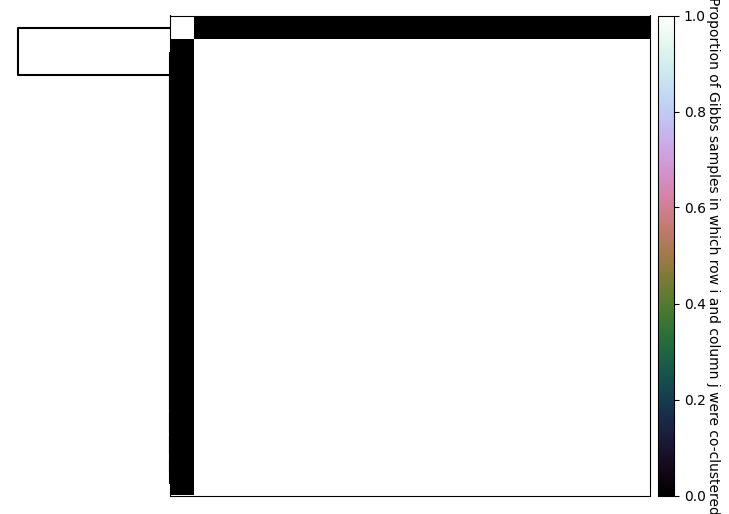

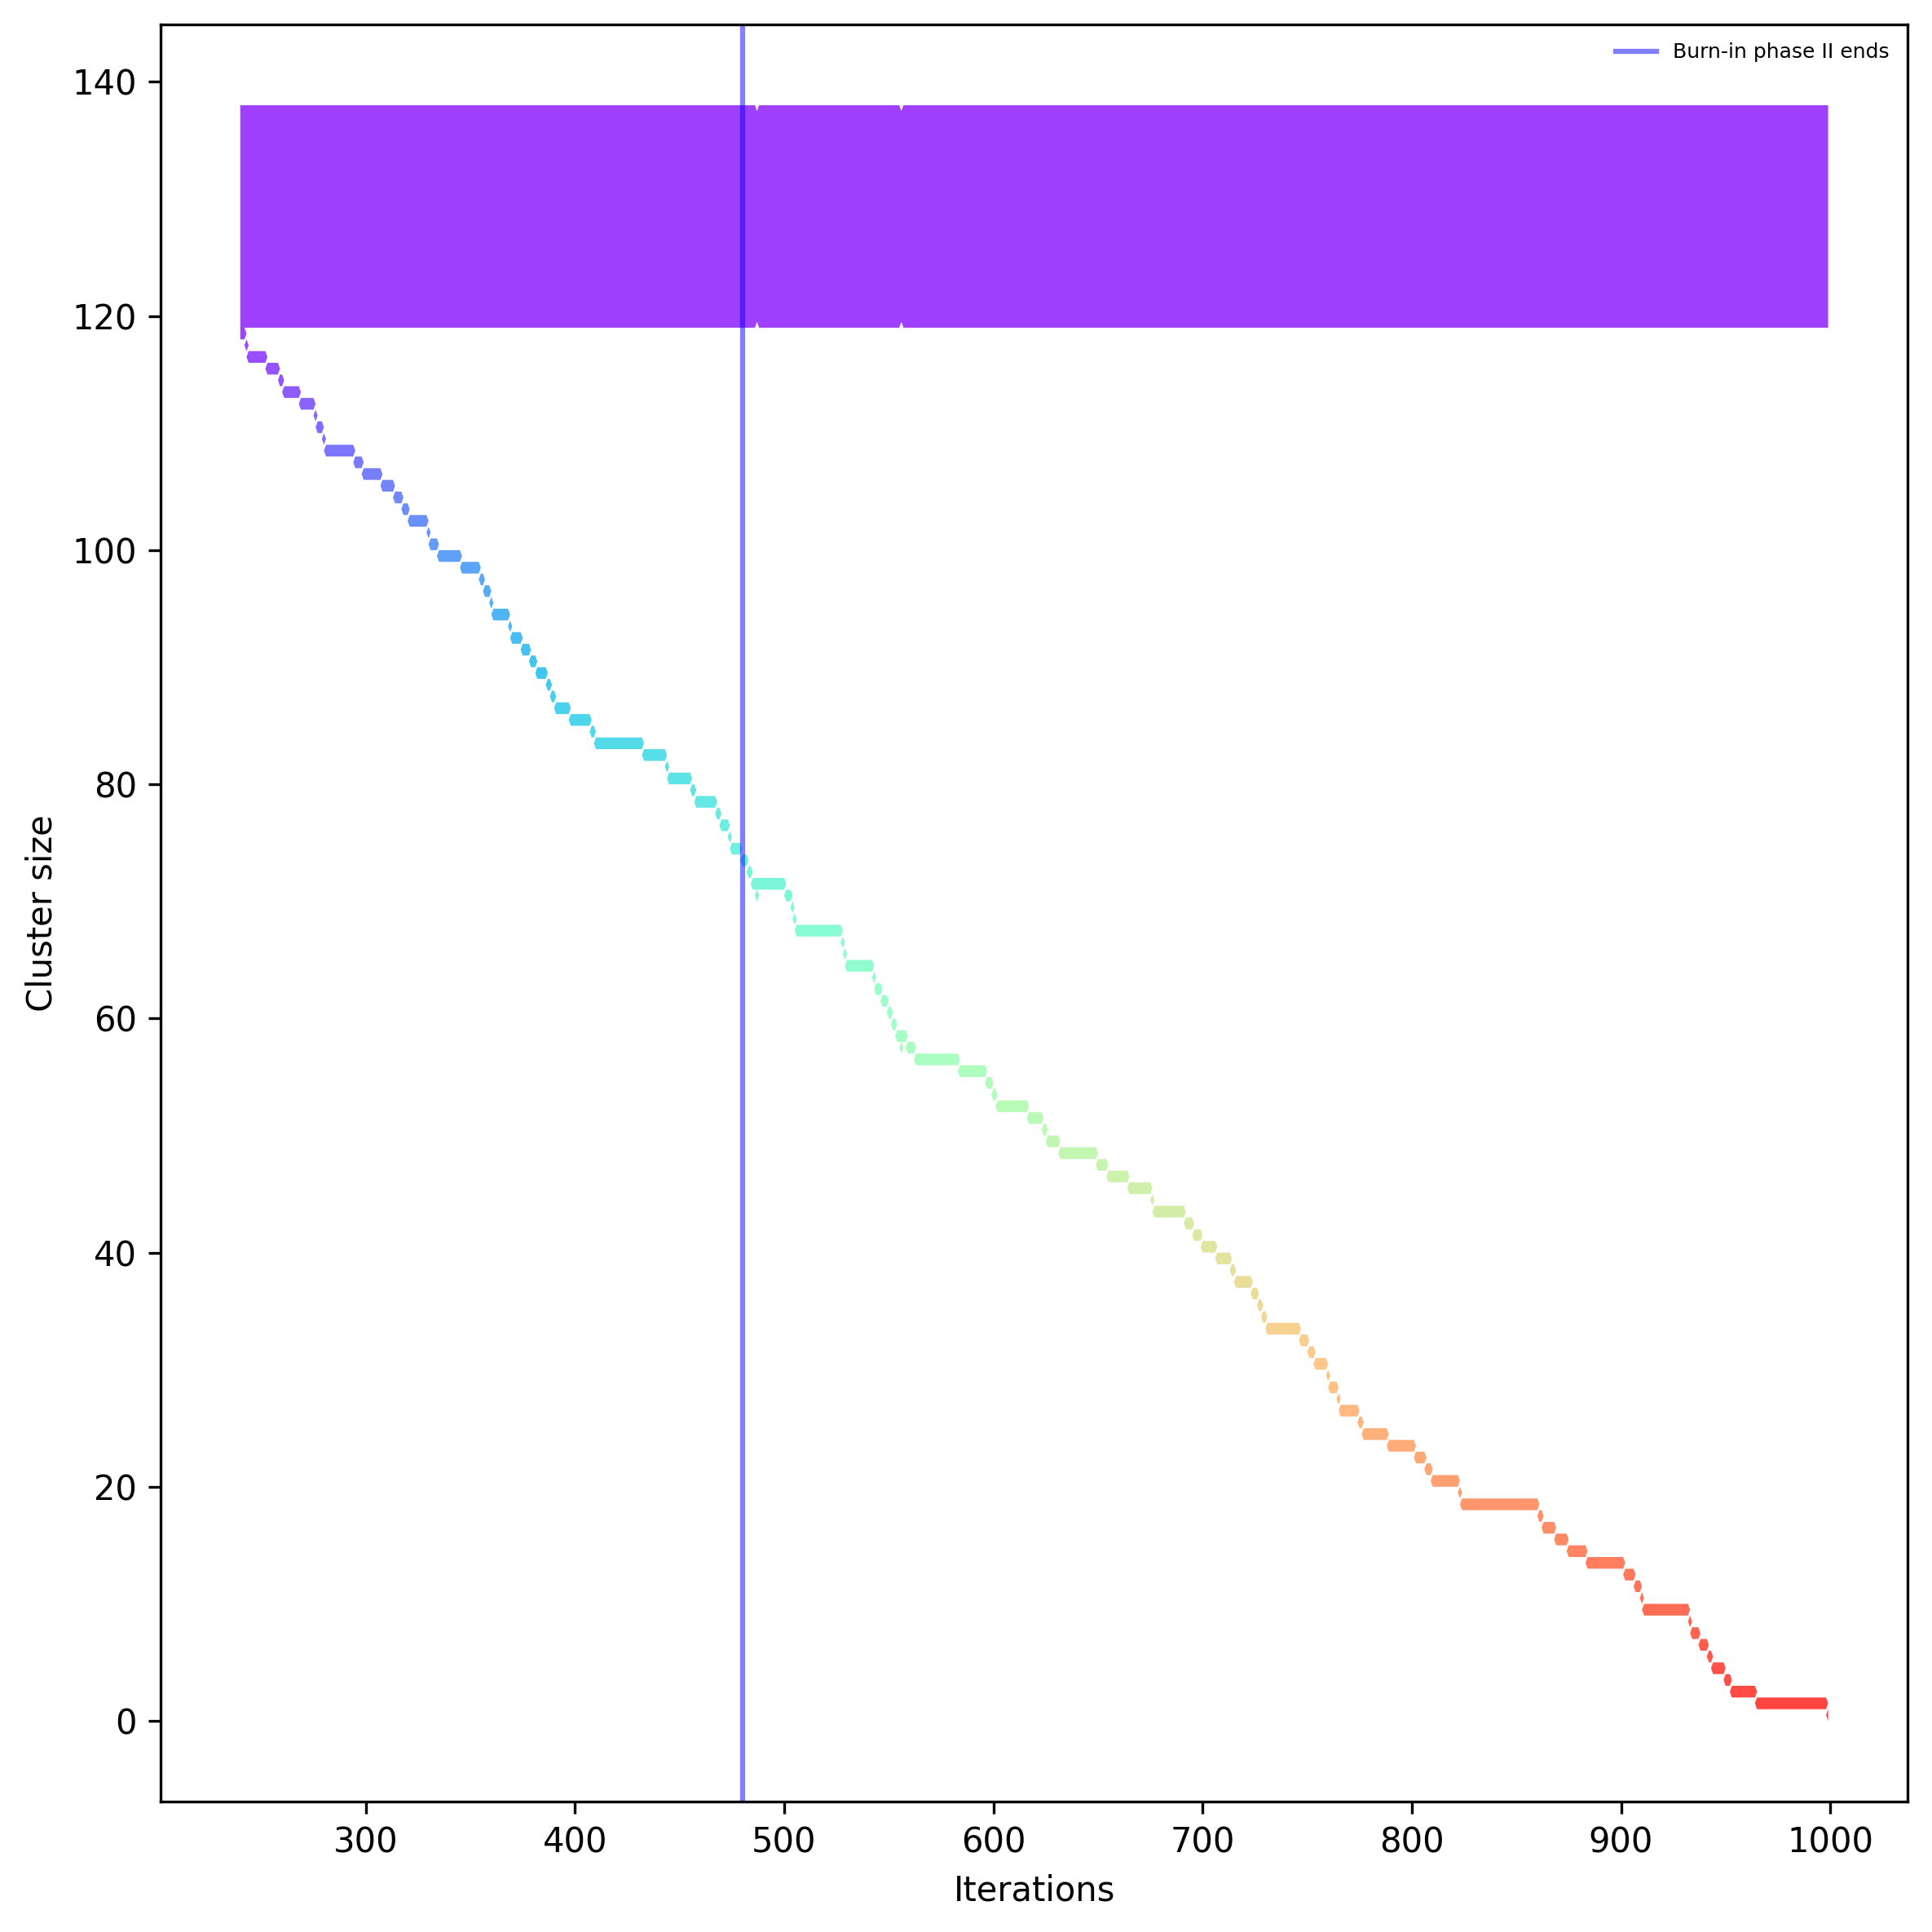

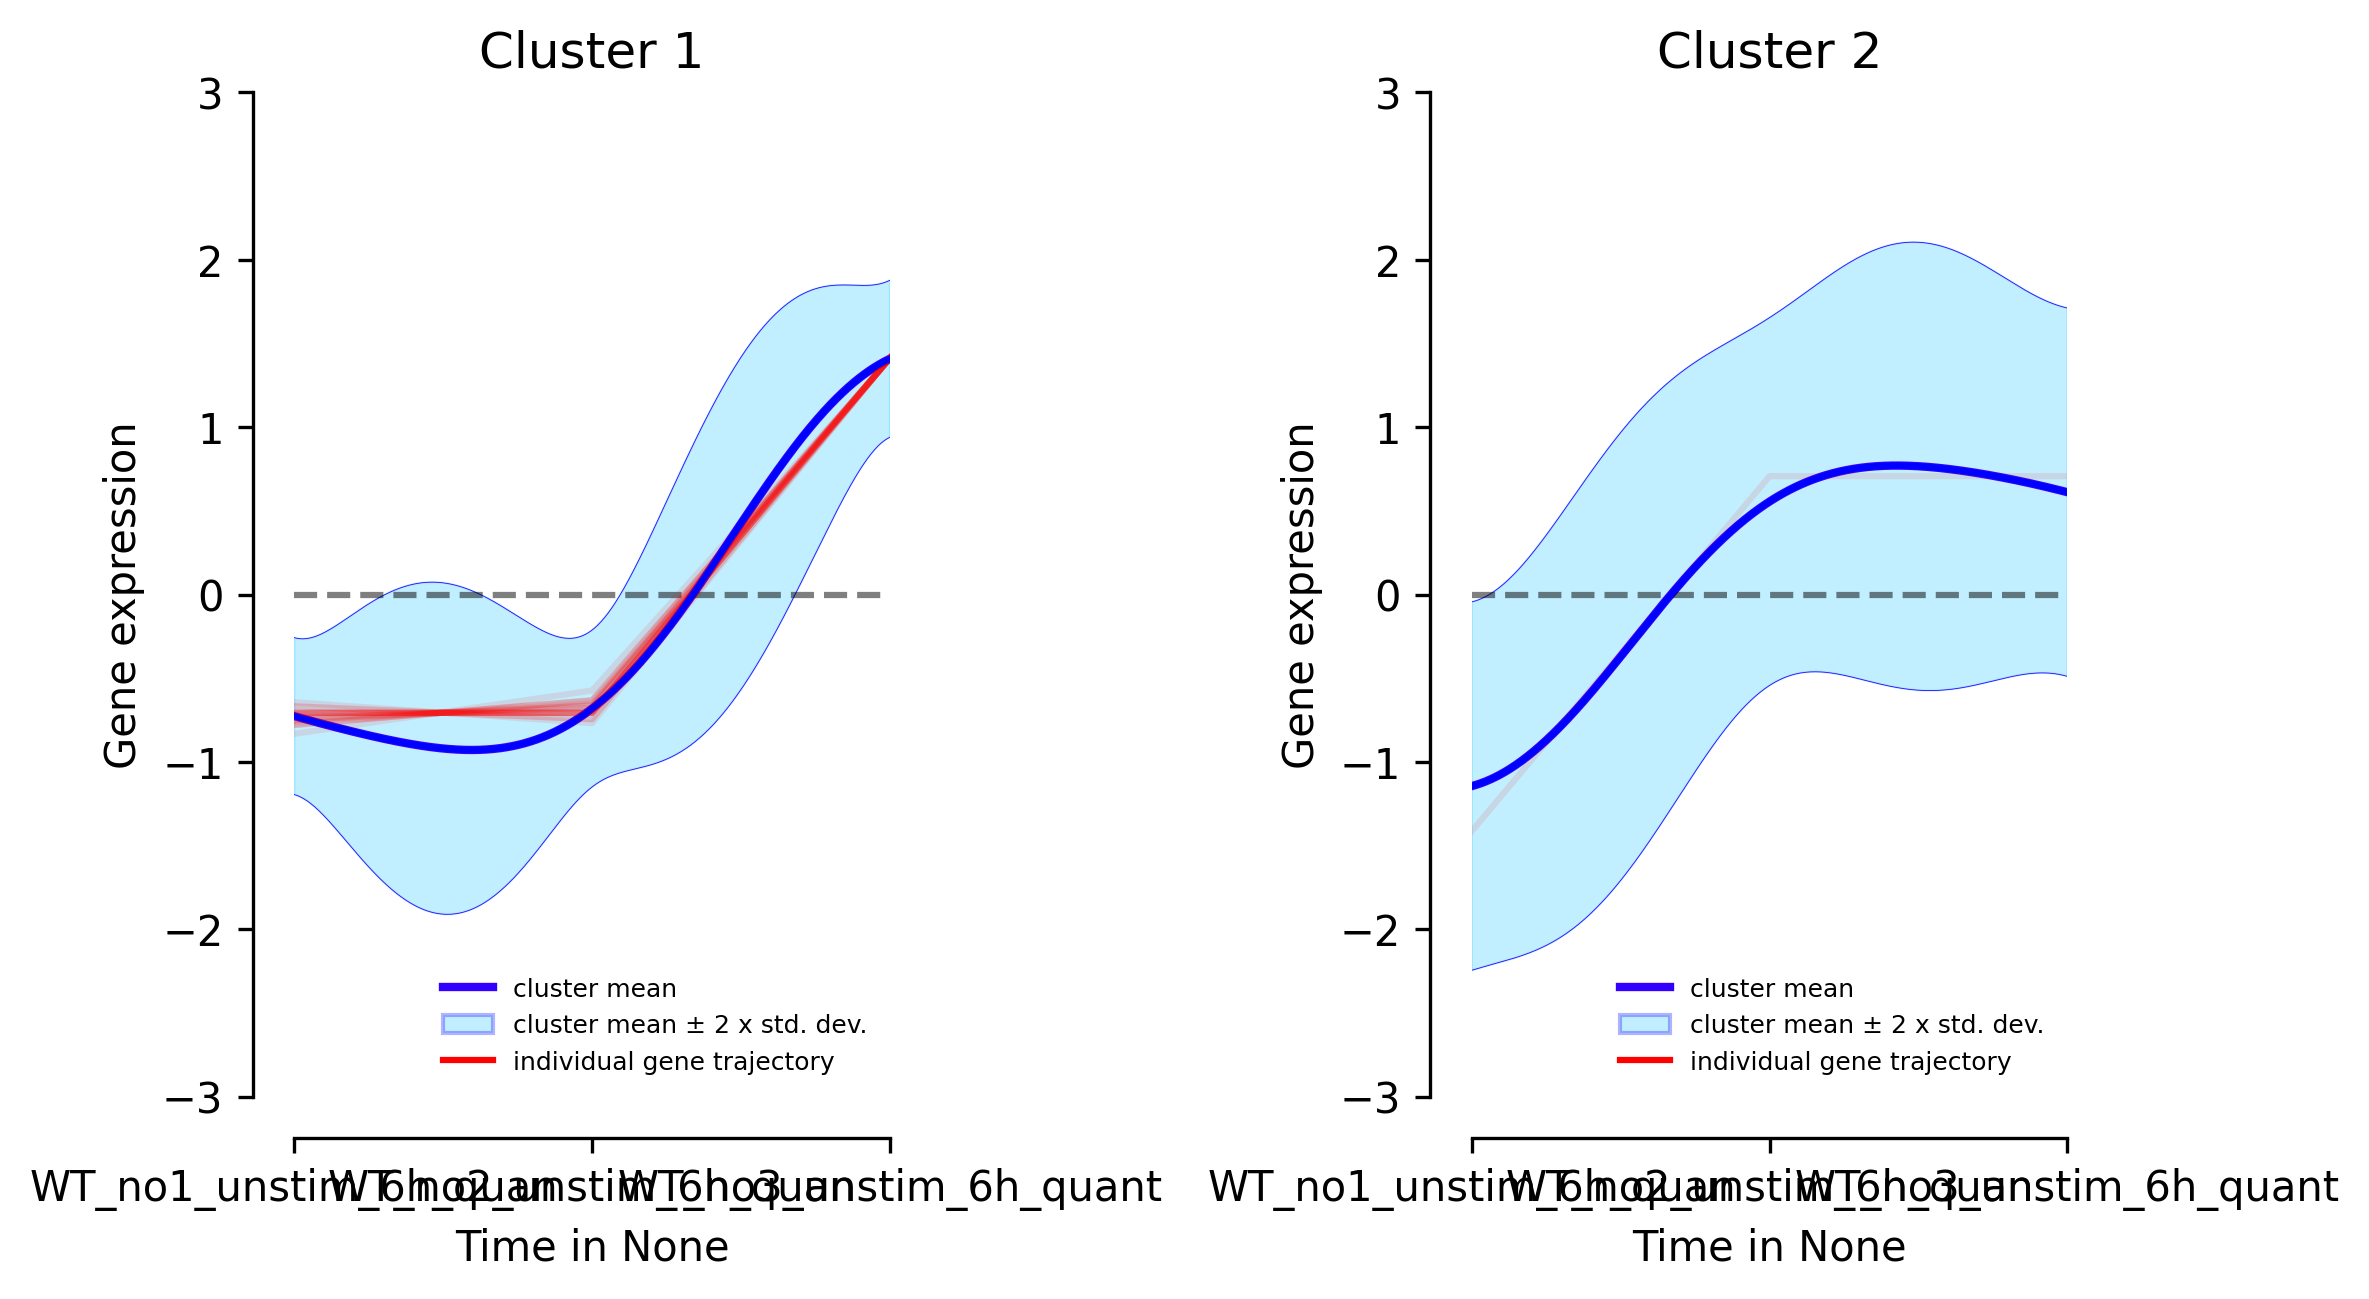

In [ ]:
if plot:
    print("Plotting expression and sampling results.")    
    plot_types = plot_types
    if not post_process or sim_mat and not do_not_plot_sim_mat:
        try:
            sim_mat_key = dp_plt.plot_similarity_matrix(
                sim_mat, output_path_prefix, plot_types
                )
        except RuntimeError:
            print("WARNING: skipping heatmap plot generation, too many dendrogram recursions for scipy to handle")
        
    if not post_process:    
        core.save_posterior_similarity_matrix_key(
            [gene_names[idx] for idx in sim_mat_key], 
            output_path_prefix
            )
        dp_plt.plot_cluster_sizes_over_iterations(
            np.array(all_clusterings), 
            burnIn_phaseI, 
            burnIn_phaseII, 
            m, 
            output_path_prefix, 
            plot_types
            )
    
    dp_plt.plot_cluster_gene_expression(
       optimal_clusters_GP,
       pd.DataFrame(
           gene_expression_matrix, index=gene_names, columns=t),
       t,
       t_labels,
       time_unit,
       output_path_prefix,
       plot_types, 
       unscaled,
       do_not_mean_center,
    )

## Save clusters

In [ ]:
if save_cluster_GPs:    
    param_df = pd.DataFrame({name:dp_cluster.model.param_array for name, dp_cluster in optimal_clusters_GP.items()}) 
    param_df.index = dp_cluster.model.parameter_names()
    param_df.to_csv(output_path_prefix + "_cluster_model_params.txt", sep='\t', index=True, header=True)